# The Treachery of Images, 1929 by Rene Magritte

![The Treachery of Images](https://raw.githubusercontent.com/asyaf/magritte/master/images/pipe.jpg)

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG19
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from google.colab import drive

import cv2
import glob
from imutils import paths
import numpy as np
from math import floor
import matplotlib.pyplot as plt
import os
import pickle
import random
from shutil import copy2
%matplotlib inline

**Load Drive**

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Constants**

In [0]:
DRIVE_ROOT = "drive/My Drive"
DATA_DIR = "Data/lecture data"
DATA_PATH = os.path.join(DRIVE_ROOT, DATA_DIR)
LE_PATH = os.path.join(DATA_PATH, "le.cpickle")
MODEL_PATH = os.path.join(DATA_PATH, "model.cpickle")
TEST_DIR = "test"
CLASSES = ["lecture", "no_lecture"]

LIGHT_YELLOW_COLOR = (230, 230, 150)
BLACK_COLOR = (0,0,0)
IMG_SIZE_FACTOR = 0.5
IMG_Y_POS = 50
POS_X_FACTOR = 0.25
POS_Y_FACTOR = 0.8

**Load VGG19 pretrained network**

In [4]:
print("loading network...")
net_model = VGG19(weights="imagenet", include_top=False)
print("Done!")
#initialize label encoder
le = None

loading network...




80142336/80134624 [==============================] - 1s 0us/step






Done!


**Run data through network and save results**

In [0]:
def preprocess_image(image_path):
	# load the input image using the Keras helper utility
	# while ensuring the image is resized to 224x224 pixels
	image = load_img(image_path, target_size=(224, 224))
	image = img_to_array(image)

	# preprocess the image by (1) expanding the dimensions and
	# (2) subtracting the mean RGB pixel intensity from the
	# ImageNet dataset
	image = np.expand_dims(image, axis=0)
	return imagenet_utils.preprocess_input(image)

**Load data from disk**

In [0]:
# load the label encoder from disk
le = pickle.loads(open(LE_PATH, "rb").read())

In [10]:
from sklearn.externals import joblib
lr_model = joblib.load(MODEL_PATH)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


**Predict example**

In [0]:
def pick_test_image(class_name=""):
  p = os.path.join(DATA_PATH, TEST_DIR)
  if class_name != "":
    p = os.path.join(p, class_name)    
  image_paths = list(paths.list_images(p))
  rand_ind = random.randint(0, len(image_paths)-1)
  test_img_path = image_paths[rand_ind]
  return test_img_path

def show_prediction(test_img_path, pred):
  print("prediction: {}".format(CLASSES[int(pred)]))
  img = plt.imread(test_img_path)
  plt.imshow(img)
  plt.show()

def predict_rand_img(class_name=""):
  # load image
  test_img_path = pick_test_image(class_name)
  test_img_prep = preprocess_image(test_img_path)

  # run through network and linear regressor
  features = net_model.predict(test_img_prep, batch_size=1)
  features = features.reshape((features.shape[0], 7 * 7 * 512))
  pred = lr_model.predict(features)

  return test_img_path, pred

Create a magritte-like image

prediction: lecture


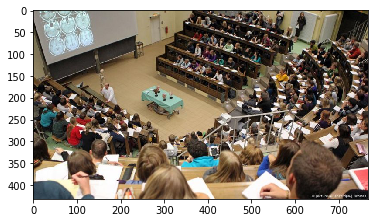

In [18]:
pred_class = CLASSES[0]
img_path, pred = predict_rand_img(pred_class)
show_prediction(img_path, pred)

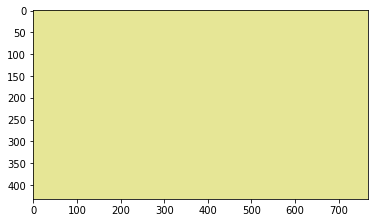

In [21]:
pred_img = plt.imread(img_path)
light_yellow_img = np.zeros(pred_img.shape, np.uint8)
light_yellow_img[:] = LIGHT_YELLOW_COLOR
plt.imshow(light_yellow_img);

In [22]:
! git clone https://github.com/asyaf/magritte
prev_dir = os.getcwd()
os.chdir("/content/magritte/code")

ROOT_DIR = os.path.abspath("..")

from utils import load_image, display_image, paste_image_with_offset, \
                  resize_image
os.chdir(prev_dir)

Cloning into 'magritte'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 146 (delta 1), reused 0 (delta 0), pack-reused 137
Receiving objects: 100% (146/146), 34.85 MiB | 52.86 MiB/s, done.
Resolving deltas: 100% (41/41), done.


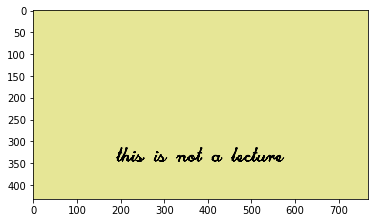

In [57]:
def add_black_text(img, text, font, font_size, pos_x, pos_y):
  res_img = img.copy()
  font_scale = min(img.shape[0], img.shape[1])/font_size
  cv2.putText(res_img,text,(pos_x,pos_y), font, font_scale,BLACK_COLOR,2,cv2.LINE_AA)
  return res_img

pos_x = light_yellow_img.shape
font = cv2.FONT_HERSHEY_SCRIPT_COMPLEX
font_size = 300
text = "this is not a {}".format(pred_class)
pos_x = int(pred_img.shape[1]*POS_X_FACTOR)
pos_y = int(pred_img.shape[0]*POS_Y_FACTOR)
bgrnd_with_txt_img = add_black_text(light_yellow_img, text, font, font_size, pos_x, pos_y)
display_image(bgrnd_with_txt_img)

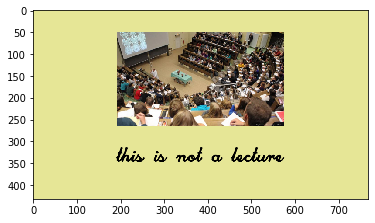

In [58]:
h, w,_ = pred_img.shape
new_h, new_w = int(h*IMG_SIZE_FACTOR), int(w*IMG_SIZE_FACTOR)
resized_pred_img = resize_image(pred_img, new_w, new_h)
bgrnd_with_txt_and_img = paste_image_with_offset(bgrnd_with_txt_img, 
                                                 resized_pred_img, 
                                                 int(w * POS_X_FACTOR), 
                                                 IMG_Y_POS)
display_image(bgrnd_with_txt_and_img)